In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import string

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:

df = pd.read_csv("IMDB Dataset.csv")
df = df.sample(10000).reset_index(drop=True)
df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})


In [3]:

class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        text = re.sub(r'<.*?>', '', text)  # Remove HTML
        text = text.lower()
        text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
        tokens = text.split()
        tokens = [word for word in tokens if word not in self.stop_words]
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens]
        return " ".join(tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.clean_text)


In [4]:

def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocess', TextPreprocessor()),
        ('vectorizer', TfidfVectorizer(max_features=5000)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\nModel: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


In [5]:

X = df['review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_and_evaluate_model(LogisticRegression(max_iter=200), X_train, X_test, y_train, y_test)
train_and_evaluate_model(MultinomialNB(), X_train, X_test, y_train, y_test)
train_and_evaluate_model(LinearSVC(), X_train, X_test, y_train, y_test)



Model: LogisticRegression
Accuracy: 0.8735
F1 Score: 0.8779546550892426
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       977
           1       0.87      0.89      0.88      1023

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000

Confusion Matrix:
 [[837 140]
 [113 910]]

Model: MultinomialNB
Accuracy: 0.835
F1 Score: 0.8382352941176471
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       977
           1       0.84      0.84      0.84      1023

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.84      0.83      0.84      2000

Confusion Matrix:
 [[815 162]
 [168 855]]

Model: LinearSVC
Accuracy: 0.864
F1 Score: 0.8670576735092864
Classificat

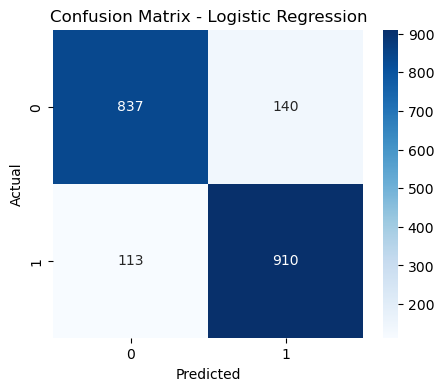

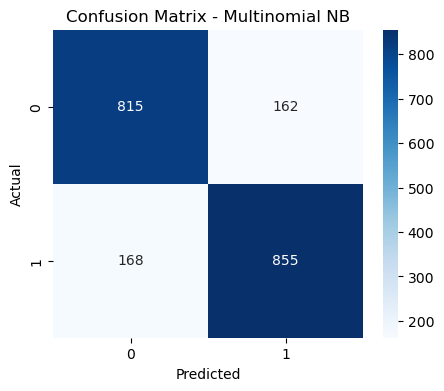

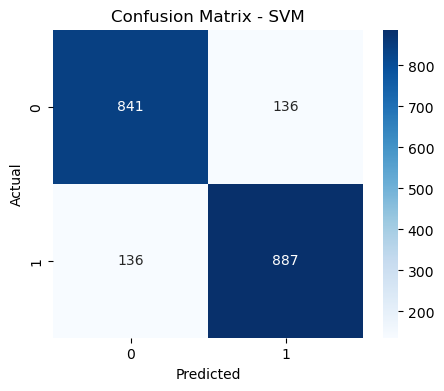

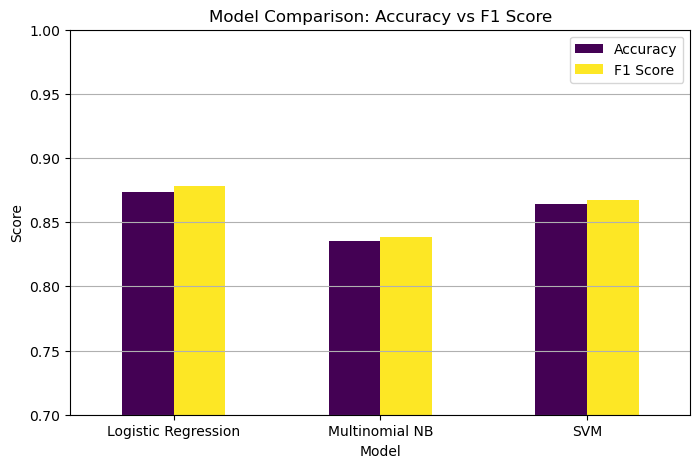

In [6]:


# Store results for visualization
results = []

models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Multinomial NB": MultinomialNB(),
    "SVM": LinearSVC()
}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocess', TextPreprocessor()),
        ('vectorizer', TfidfVectorizer(max_features=5000)),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append((name, acc, f1))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot comparison of accuracy and F1
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "F1 Score"])
results_df.set_index("Model", inplace=True)
results_df.plot(kind="bar", figsize=(8, 5), colormap='viridis')
plt.title("Model Comparison: Accuracy vs F1 Score")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.ylim(0.7, 1.0)
plt.grid(axis='y')
plt.show()
